In [1]:
import integrated_cell
from integrated_cell import model_utils, utils
import json
import os

#'/allen/aics/modeling/gregj/results/integrated_cell/test_vaegan2D_proj/2018-11-28-01:27:48'
save_dir = '/root/results/integrated_cell/test_vaegan2D_proj/2018-11-28-01:27:48'

args_file = '{}/args.json'.format(save_dir)

with open(args_file, 'r') as f:
    args = json.load(f)

/root/projects/pytorch_integrated_cell/integrated_cell/model_utils.py:12: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use("Agg")


In [2]:

    
args['save_dir'] = '{}/{}'.format(save_dir, args['ref_dir'])
    
dp_name, dp_kwargs = utils.save_load_dict(
    "{}/args_dp.json".format(args["save_dir"])
)
dp_kwargs['save_path'] = dp_kwargs['save_path'].replace('./', '/root/results/integrated_cell/')
dp = model_utils.load_data_provider(dp_name, **dp_kwargs)

net_names = ['enc', 'dec']
net_kwargs = {}
networks = {}

for net_name in net_names:
    args_save_path = "{}/args_{}.json".format(args["save_dir"], net_name)
    net_kwargs[net_name] = utils.save_load_dict(args_save_path)
    net_kwargs[net_name]['save_path'] = net_kwargs[net_name]['save_path'].replace('./', '/root/results/integrated_cell/')
    
    networks[net_name], _ = utils.load_network(**net_kwargs[net_name])

enc = networks['enc']
dec = networks['dec']



/root/projects/pytorch_integrated_cell/integrated_cell/utils/utils.py:56: UserWarning: args file exists and overwrite is not set to True. Using existing args file.
  "args file exists and overwrite is not set to True. Using existing args file."
/root/projects/pytorch_integrated_cell/integrated_cell/utils/utils.py:56: UserWarning: args file exists and overwrite is not set to True. Using existing args file.
  "args file exists and overwrite is not set to True. Using existing args file."
/root/projects/pytorch_integrated_cell/integrated_cell/utils/plots.py:7: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use("Agg")


loading from /root/results/integrated_cell/test_vaegan2D_proj/2018-11-28-01:27:48/ref_model/enc.pth


/root/projects/pytorch_integrated_cell/integrated_cell/utils/utils.py:56: UserWarning: args file exists and overwrite is not set to True. Using existing args file.
  "args file exists and overwrite is not set to True. Using existing args file."


loading from /root/results/integrated_cell/test_vaegan2D_proj/2018-11-28-01:27:48/ref_model/dec.pth


In [3]:
import torch
import tqdm

def get_latent_embeddings(enc, dp):
    enc.eval()
    gpu_id = enc.gpu_ids[0]

    modes = ("test", "train")

    embedding = dict()

    for mode in modes:
        ndat = dp.get_n_dat(mode)
        embeddings_ref_mu = torch.zeros(ndat, enc.n_latent_dim)
        embeddings_struct_mu = torch.zeros(ndat, enc.n_latent_dim)        

        embeddings_ref_sigma = torch.zeros(ndat, enc.n_latent_dim)
        embeddings_struct_sigma = torch.zeros(ndat, enc.n_latent_dim)        
        
        inds = list(range(0, ndat))
        data_iter = [
            inds[i : i + dp.batch_size]  # noqa
            for i in range(0, len(inds), dp.batch_size)
        ]

        for i in tqdm.tqdm(range(0, len(data_iter))):
            x, classes, ref = dp.get_sample(mode, data_iter[i])
            
            x = x.cuda()
            classes_onehot = utils.index_to_onehot(classes, dp.get_n_classes()).cuda()
            
            with torch.no_grad():
                zAll = enc(x, classes_onehot)
                
            embeddings_ref_mu.index_copy_(
                0, torch.LongTensor(data_iter[i]), zAll[0][0].data[:].cpu()
            )
            embeddings_ref_sigma.index_copy_(
                0, torch.LongTensor(data_iter[i]), zAll[0][1].data[:].cpu()
            )
            
            embeddings_struct_mu.index_copy_(
                0, torch.LongTensor(data_iter[i]), zAll[1][0].data[:].cpu()
            )
            embeddings_struct_sigma.index_copy_(
                0, torch.LongTensor(data_iter[i]), zAll[1][0].data[:].cpu()
            )

        embedding[mode] = {}
        embedding[mode]['ref'] = {}
        embedding[mode]['ref']['mu'] = embeddings_ref_mu
        embedding[mode]['ref']['sigma'] = embeddings_ref_sigma
        
        embedding[mode]['struct'] = {}
        embedding[mode]['struct']['mu'] = embeddings_struct_mu
        embedding[mode]['struct']['sigma'] = embeddings_struct_mu        
        
    return embedding

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

dpi = 100
figx = 6
figy = 4.5

def embedding_variation(embeddings, figsize = (8, 4), save_path = None):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    colors = cm.viridis(np.linspace(0,1, 1))
    
    color = colors[0]
    
    variation = np.var(embeddings, axis=0)
    variation_argsort = np.argsort(variation)[::-1]
    
    var_dims = np.sort(variation)[::-1]
    ax1.plot(var_dims, color = color)
    ax1.set_xlabel('dimension #')
    ax1.set_ylabel('dimension variation')
    ax1.set_ylim(0, 1.5)

    ax2.plot(np.cumsum(var_dims)/np.sum(var_dims), color = color)
    ax2.set_xlabel('dimension #')
    ax2.set_ylabel('cumulative variation')

    fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=dpi)
        plt.close()
        
    return variation

def get_item_kl_divergences(embeddings):
    kls = {}

    modes = ["train", "test"]
    components = ['ref', 'struct']
    for mode in modes:
        kls[mode] = {}
        for component in components:

            component_kl = []
            for mu, sigma in zip(embeddings[mode][component]['mu'], embeddings[mode][component]['sigma']):

                kl, _, _ = bvae.kl_divergence(mu.unsqueeze(0), sigma.unsqueeze(0))
                component_kl.append(kl.numpy())

            kls[mode][component] = np.hstack(component_kl)
            
    return kls

In [33]:
results_dir = '{}/results'.format(save_dir)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

embeddings_path = '{}/embeddings.pth'.format(results_dir)
klds_path = '{}/klds.pth'.format(results_dir)
dimension_variation_path = '{}/dimension_variation.pth'.format(results_dir)

if not os.path.exists(embeddings_path):
    embeddings = get_latent_embeddings(enc, dp)
    torch.save(embeddings, embeddings_path)
else:
    embeddings = torch.load(embeddings_path)
    
if not os.path.exists(klds_path):
    klds = get_item_kl_divergences(embeddings)
    torch.save(klds, klds_path)
else:
    klds = torch.load(klds_path)

if not os.path.exists(dimension_variation_path):
    dimension_variation = {}
    dimension_variation['ref'] = embedding_variation(embeddings['train']['ref']['mu'].numpy(), save_path = "{}/variation_ref.png".format(results_dir))
    dimension_variation['struct'] = embedding_variation(embeddings['train']['struct']['mu'].numpy(), save_path = "{}/variation_struct.png".format(results_dir))
    torch.save(dimension_variation, dimension_variation_path)
else:
    dimension_variation = torch.load(dimension_variation_path)


/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(-0.5, 1439.5, 2429.5, -0.5)

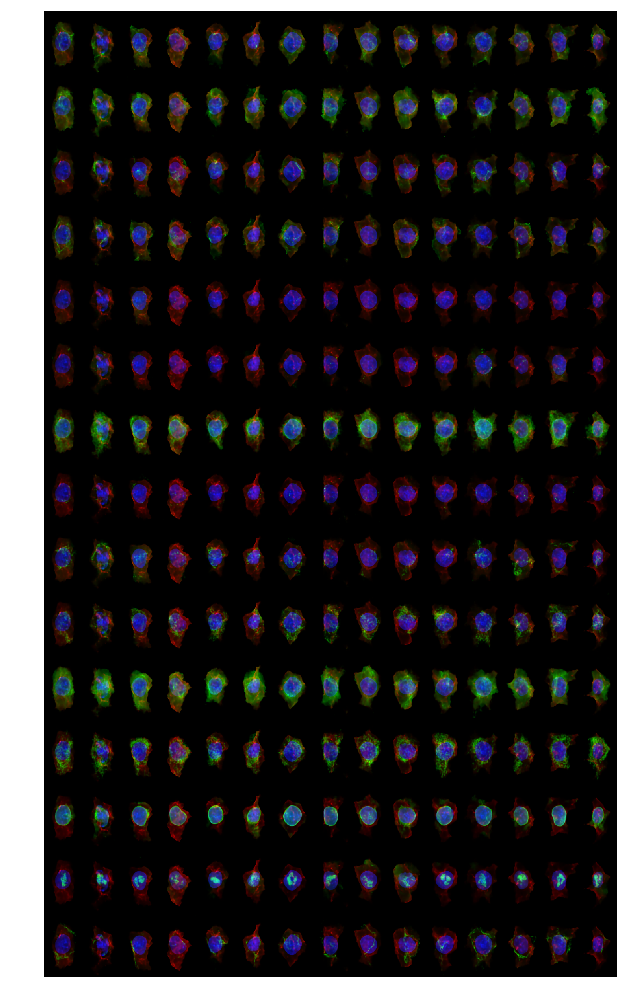

In [72]:
#randomly sample cells


from scipy.misc import imsave

enc.train(False)
enc = enc.eval()

dec.train(False)
dec = dec.eval()


gpu_id = 0

dim_order = np.argsort(dimension_variation['ref'])[::-1]

n_imgs = 15
n_dims = args['n_latent_dim']
n_classes = args['kwargs_dec']['n_classes']



img_list = list()
for i in range(15):
    dim = dim_order[i]

#     vec_ref = torch.zeros(n_imgs,n_dims).float().cuda(gpu_id)
#     vec_ref[:,dim] = torch.linspace(-4.5, 4.5, n_imgs)
    
#     vec_ref.normal_()

    vec_struct = torch.zeros(n_imgs,n_dims).float().cuda(gpu_id)
    vec_struct.normal_()
    
    vec_class = torch.zeros(n_imgs, n_classes).float().cuda(gpu_id)
    vec_class[:, i] = 1
                       
    img_out = dec([vec_class, vec_ref, vec_struct]).detach().cpu()

    im_t = torch.tensor(img_out.numpy())
    imxy = model_utils.tensor2img(im_t)
#     imyz = model_utils.tensor2img(im_t.transpose(2,4))
#     img_flat = np.vstack([imxy,imyz])
    img_flat = imxy

    
    img_flat = img_flat
    img_flat = np.vstack([img_flat, np.zeros([2, img_flat.shape[1], 3])])
    
    
    img_list += [img_flat]
    
im_out = np.vstack(img_list)
imsave('{}/sampled.png'.format(results_dir), im_out)
# imsave('./dims.png', im_out)

# im_out[:,:,1] = 0

plt.figure(num=None, figsize=(24, 16), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(im_out)
plt.axis('off')

In [35]:
dim_order = np.argsort(dimension_variation['ref'])[::-1]

In [37]:
dimension_variation['ref'][dim_order]

array([0.10216819, 0.09792973, 0.0932142 , 0.09167346, 0.09119106,
       0.08689975, 0.08043493, 0.07700904, 0.07585056, 0.07317732,
       0.07291153, 0.07290844, 0.0725587 , 0.07223738, 0.07153925,
       0.07089145, 0.07079168, 0.07032377, 0.06993375, 0.06921698,
       0.06805952, 0.06771421, 0.06680574, 0.06680544, 0.06621309,
       0.06614832, 0.06603871, 0.06593589, 0.06575093, 0.06535431,
       0.06467868, 0.06304303, 0.060646  , 0.06053189, 0.06035238,
       0.06017506, 0.06015023, 0.06002084, 0.059067  , 0.05889837,
       0.05814307, 0.05777704, 0.05754014, 0.05698258, 0.05690455,
       0.05675698, 0.05657906, 0.05553556, 0.05527835, 0.05514544,
       0.05486495, 0.05439794, 0.05404287, 0.05382803, 0.0537052 ,
       0.05318895, 0.05286913, 0.05223836, 0.0521678 , 0.04992552,
       0.04931659, 0.04828051, 0.04825126, 0.04805997, 0.04779338,
       0.04753809, 0.04731657, 0.04238191, 0.04220439, 0.04081469,
       0.0391317 , 0.0379159 , 0.03702943, 0.00636199, 0.00620

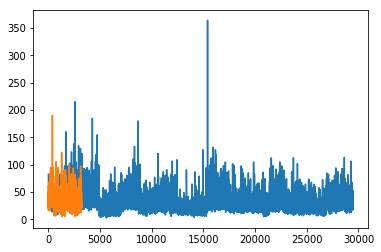

In [76]:
plt.plot(np.hstack(kls['train']['struct']))
plt.plot(np.hstack(kls['test']['struct']))